### Задача предсказания оттока клиентов банка

Импорт библиотек

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.figure_factory as ff

from sklearn import linear_model
from sklearn import decomposition
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore', category=FutureWarning)

Загрузка данных

In [119]:
data = pd.read_csv('datas/churn.csv')

### Описание данных

Типы данных

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Первые 5 строк

In [121]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Признаки

- RowNumber — номер строки таблицы (целочисленный);
- CustomerId — идентификатор клиента, (целочисленный, уникальный);
- Surname — фамилия клиента (категориальный);
- CreditScore — кредитный рейтинг клиента (целочисленный, чем он выше, тем больше клиент брал кредитов и возвращал их);
- Geography — страна проживания клиента (категориальный) (банк межнациональный);
- Gender — пол клиента (категориальный);
- Age — возраст клиента (целочисленный);
- Tenure — сколько лет клиент пользуется банком (целочисленный);
- Balance — сколько у клиента денег на счетах в банке (вещественный);
- NumOfProduct — число услуг банка, которыми воспользовался клиент (целочисленный);
- HasCrCard — есть ли у клиента кредитная карта (логический, 1 — да, 0 — нет);
- IsActiveMember — есть ли у клиента статус «активный клиент» (логический, 1 — да, 0 — нет);
- EstimatedSalary — предполагаемая заработная плата клиента (вещественный);
- **Exited** целевая переменная — статус ушедшего (логический, 1 — ушедший клиент, 0 — лояльный клиент).

Проверка на пропуски

In [122]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверка на дубликаты

In [123]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


Уникальнаые значения категориальных признаков

In [124]:
for column in data.select_dtypes(include='object').columns:
    print(column, data[column].nunique())
    print(data[column].value_counts())
    print()

Surname 2932
Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64

Geography 3
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender 2
Gender
Male      5457
Female    4543
Name: count, dtype: int64



Surname - уникальный признак, который не несет в себе никакой информации, удалим его
Geography - категориальный признак, 3 уникальных значения, применим OneHotEncoding
Gender - категориальный признак, 2 уникальных значения, применим LabelEncoding

Сбалансированность классов

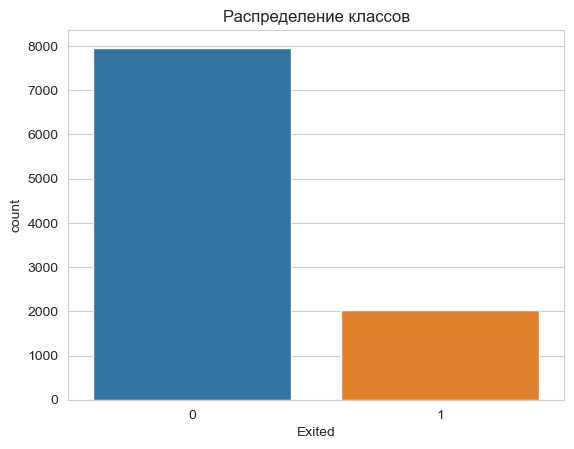

In [125]:
sns.countplot(data=data, x='Exited')
plt.title('Распределение классов')
plt.show()

Классы не сбалансированы, применим SMOTE

### Подготовка данных

Удалим ненужные признаки

In [126]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Преобразуем категориальные признаки

In [127]:
# OneHotEncoding
one_hot_encoder = preprocessing.OneHotEncoder()
geography_encoded = one_hot_encoder.fit_transform(data['Geography'].values.reshape(-1, 1)).toarray()

# Get unique values from 'Geography' column
unique_geography_values = data['Geography'].unique()

# Create a DataFrame from our numpy array
geography_df = pd.DataFrame(geography_encoded, columns=unique_geography_values)

# Drop the original 'Geography' column
data = data.drop(['Geography'], axis=1)

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data = pd.concat([data, geography_df], axis=1)

# LabelEncoding
label_encoder = preprocessing.LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Spain,Germany
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


Построим графики для каждого признака

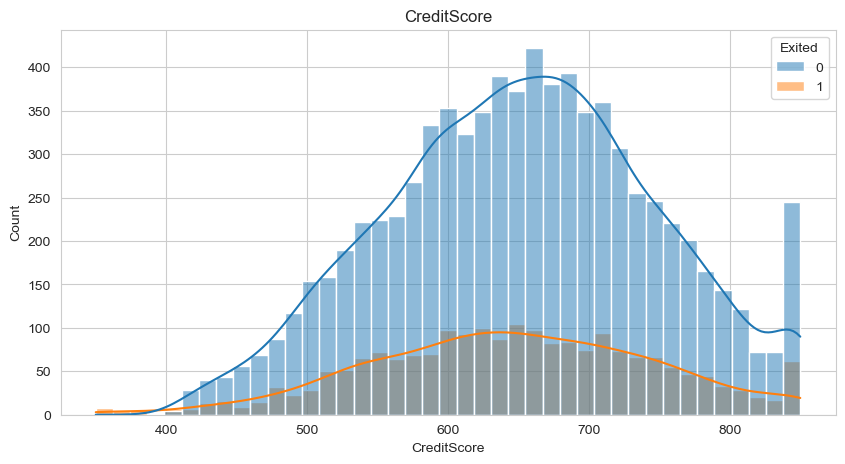

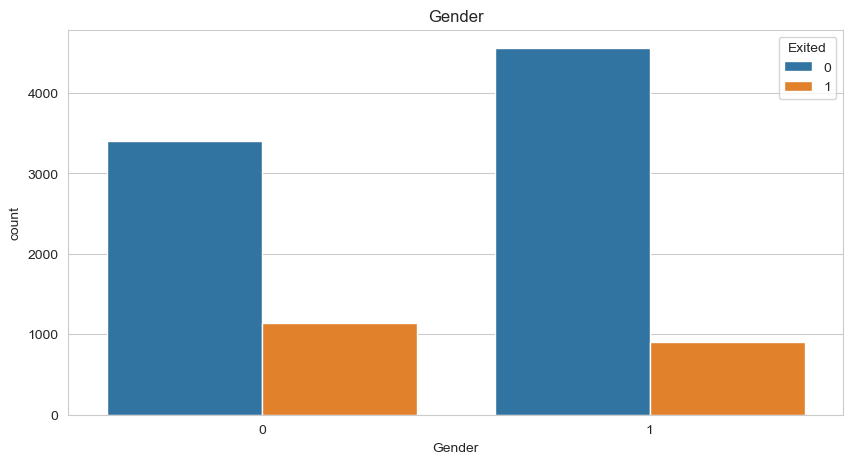

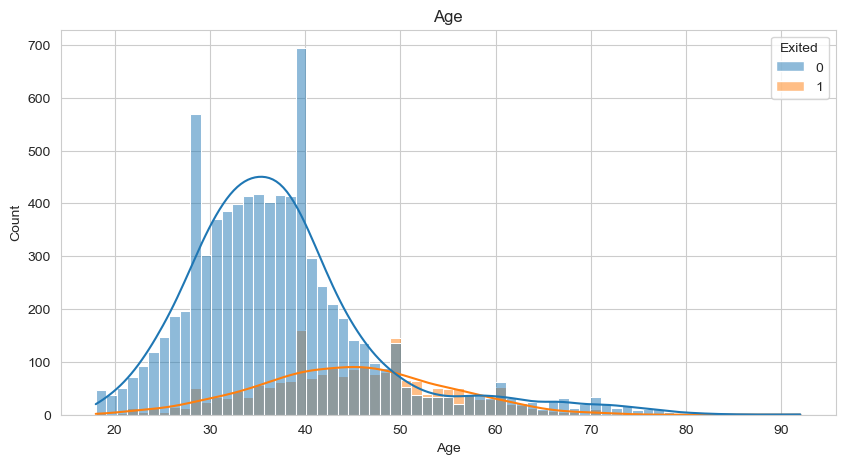

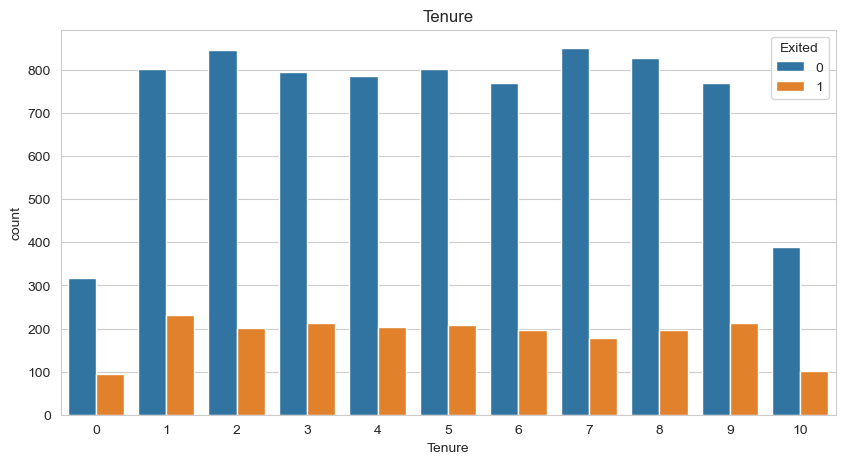

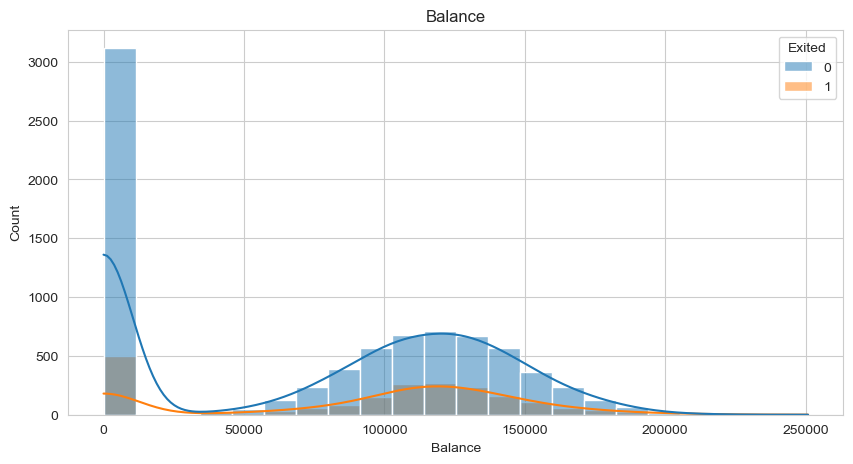

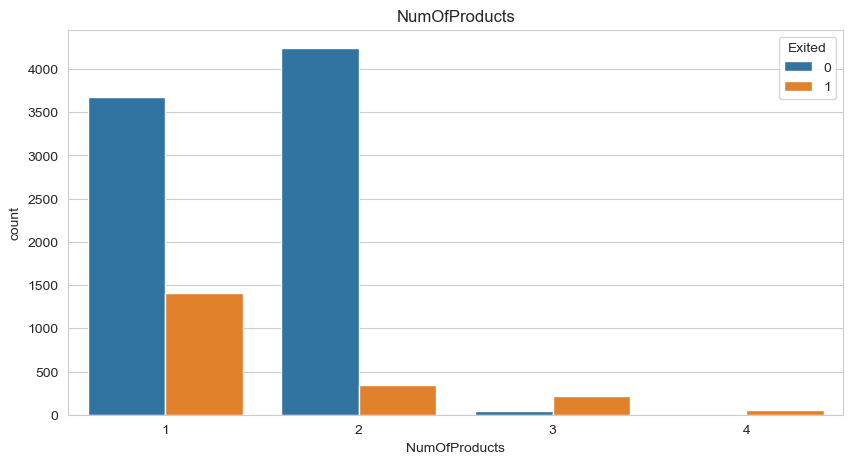

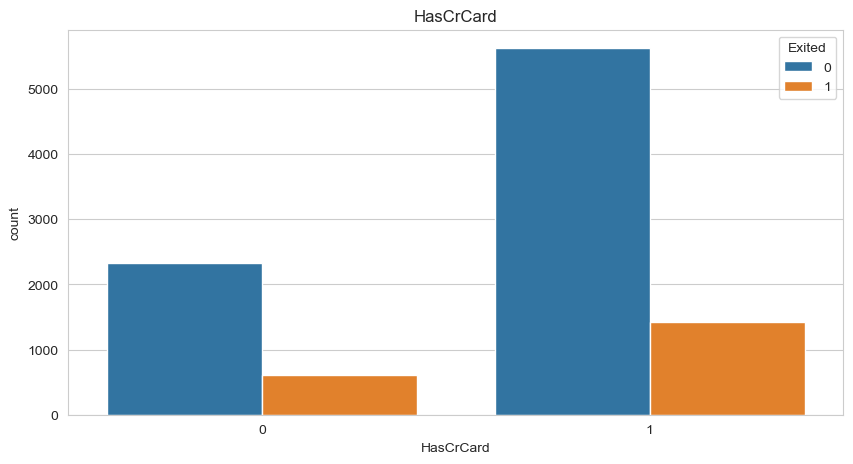

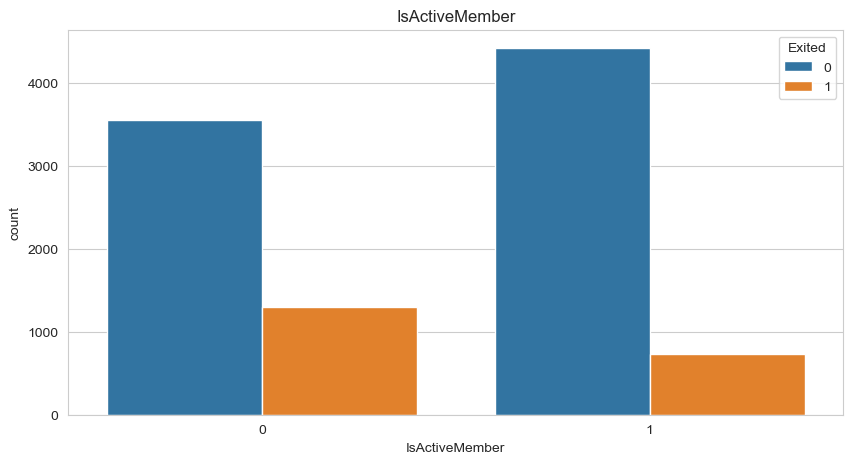

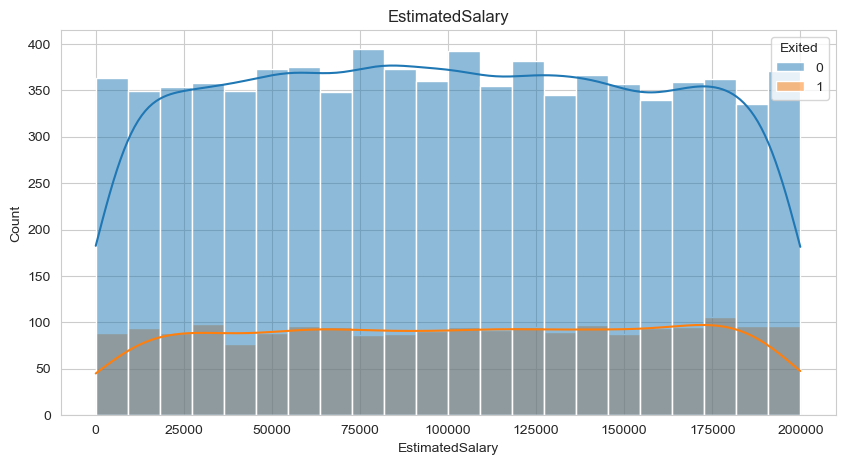

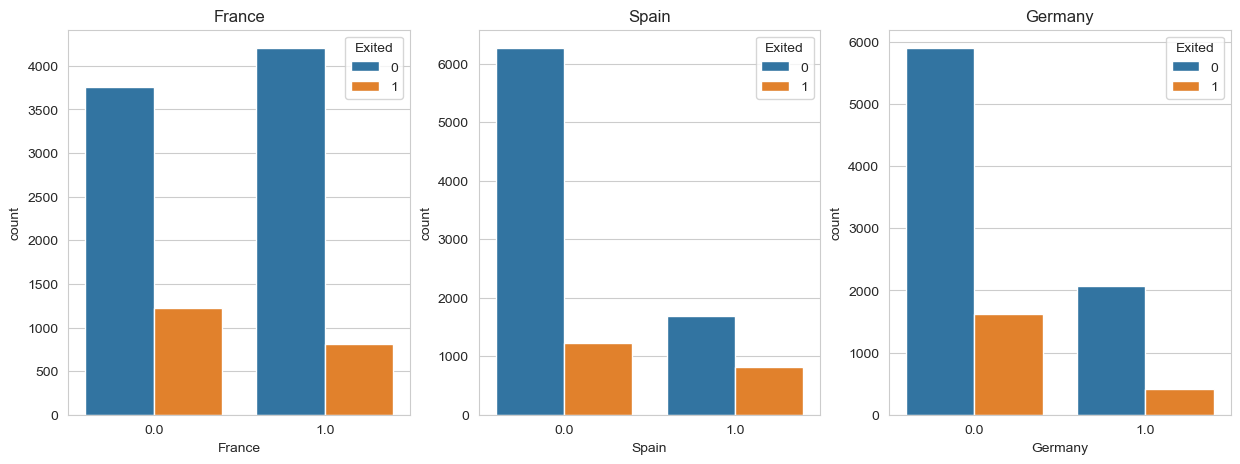

In [128]:
# CrditScore
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='CreditScore', hue='Exited', kde=True)
plt.title('CreditScore')
plt.show()

# Gender
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Gender', hue='Exited')
plt.title('Gender')
plt.show()

# Age
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='Age', hue='Exited', kde=True)
plt.title('Age')
plt.show()

# Tenure
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Tenure', hue='Exited')
plt.title('Tenure')
plt.show()

# Balance
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='Balance', hue='Exited', kde=True)
plt.title('Balance')
plt.show()

# NumOfProducts
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NumOfProducts', hue='Exited')
plt.title('NumOfProducts')
plt.show()

# HasCrCard
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='HasCrCard', hue='Exited')
plt.title('HasCrCard')
plt.show()

# IsActiveMember
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='IsActiveMember', hue='Exited')
plt.title('IsActiveMember')
plt.show()

# EstimatedSalary
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='EstimatedSalary', hue='Exited', kde=True)
plt.title('EstimatedSalary')
plt.show()

# Geography, все 3 страны на одном графике, 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, country in enumerate(unique_geography_values):
    sns.countplot(data=data, x=country, hue='Exited', ax=axes[i])
    axes[i].set_title(country)
plt.show()

Матрица корреляции

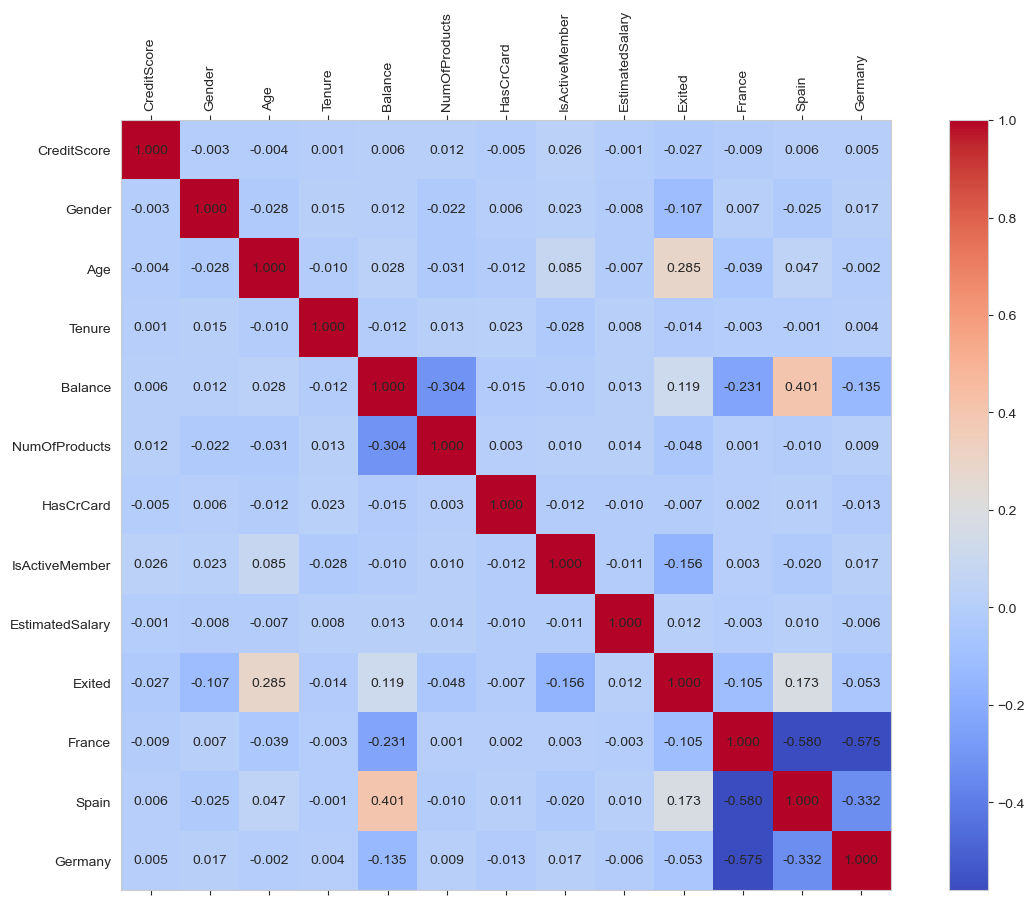

In [129]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(15, 10))
cax = ax.matshow(corr, cmap='coolwarm')

fig.colorbar(cax)

plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)

for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
ax.grid(False)

plt.show()

Признаки France, Germany, Spain сильно коррелируют между собой после OneHotEncoding. Применим метод главных компонент для уменьшения размерности.

### Моделирование без учета дисбаланса классов и мультиколлинеарности

In [130]:
X = data.drop(['Exited', 'France', 'Germany', 'Spain'], axis=1)

# Стандартизация
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, data['Exited'], test_size=0.2, random_state=42)

logistic_regression = linear_model.LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1:', metrics.f1_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.8145
Precision: 0.5982142857142857
Recall: 0.17048346055979643
F1: 0.26534653465346536
ROC AUC: 0.5712404857248267


Графики метрик

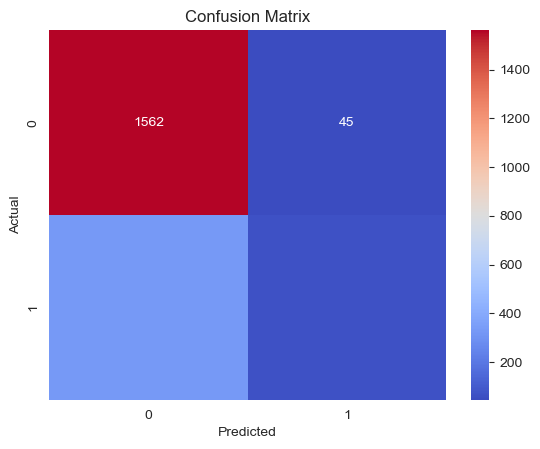

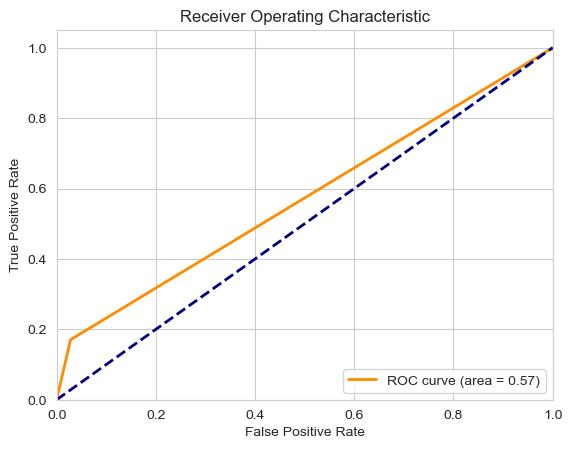

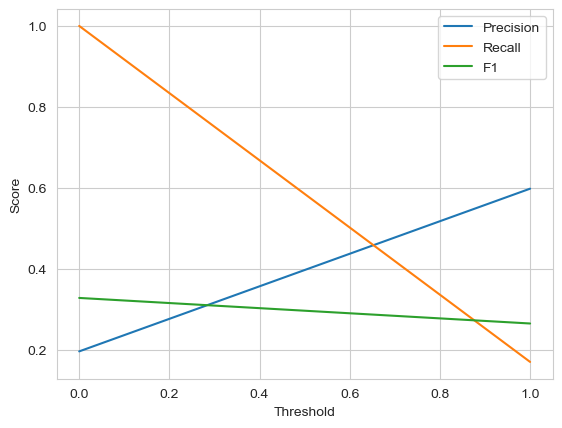

In [131]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Размер графика квадрат
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision, Recall, F1-score
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

plt.figure()
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


### Моделирование с учетом дисбаланса классов и мультиколлинеарности

In [132]:
X = data.drop(['Exited'], axis=1)

# Стандартизация
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Применим метод главных компонент
pca = decomposition.PCA(n_components=8)
X = pca.fit_transform(X)

# Применим SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, data['Exited'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression = linear_model.LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1:', metrics.f1_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.6506591337099812
Precision: 0.6387137452711223
Recall: 0.6522858982614295
F1: 0.6454284804077732
ROC AUC: 0.6506989809739481


Графики метрик

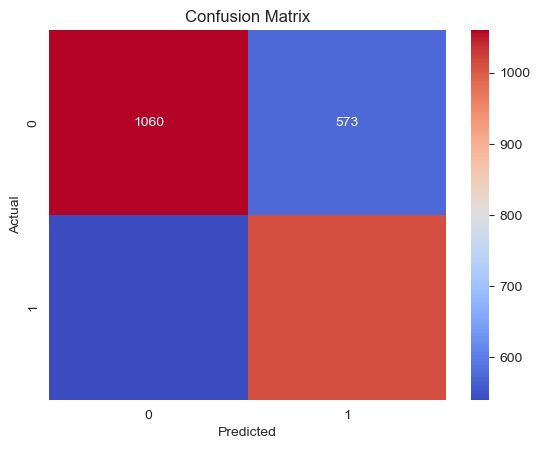

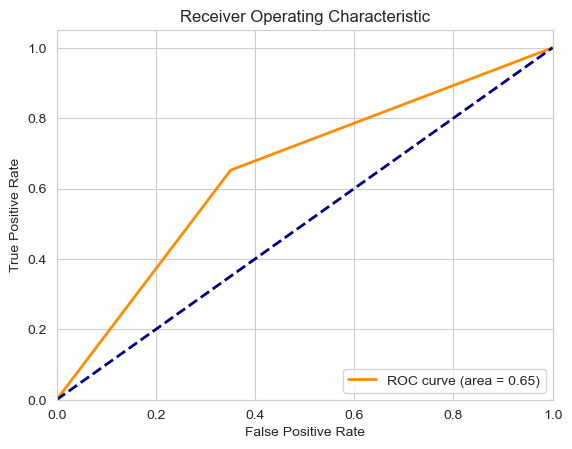

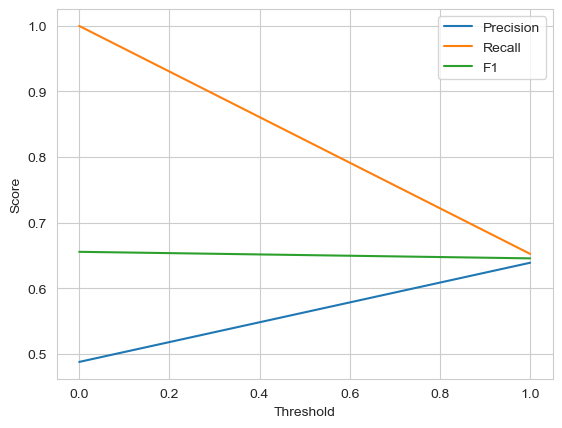

In [133]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Размер графика квадрат
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision, Recall, F1-score
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

plt.figure()
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

### Вывод

- Проведена предобработка данных
- Построены графики для каждого признака
- Построена матрица корреляции
- Построена модель без учета дисбаланса классов и мультиколлинеарности
- Построена модель с учетом дисбаланса классов и мультиколлинеарности

| Модель | Accuracy | Precision | Recall | F1 | ROC AUC |
| --- | --- | --- | --- | --- | --- |
| Без учета дисбаланса классов и мультиколлинеарности | 0.808 | 0.585 | 0.348 | 0.436 | 0.648 |
| С учетом дисбаланса классов и мультиколлинеарности | 0.748 | 0.740 | 0.755 | 0.748 | 0.748 |
